Zadanie polega na stworzeniu sieci neuronowej, która będzie wykrywać
położenie początku i końca linii na obrazie o rozmiarze 64x64 punkty
(pixele).  
Dla uproszczenia zakładamy, że na obrazie znajduje się tylko
jedna czarna cienka linia na białym tle.  
Algorytm powinien na wyjściu
podawać współrzędne x i y początku i końca lini która znajduje się na
obrazie podanym na wejście.  
Zakładam że w ramach rozwiązana przygotujesz:

1.   Algorytm generujący zbiór uczący
2.   Architekturę sieci
3.   Wyuczysz algorytm
4.   Podasz jego skuteczność


## Generowanie zbioru danych

In [646]:
from tensorflow.keras.utils import load_img, img_to_array
import cv2
import numpy as np
import matplotlib as plt
import random
import pandas as pd
import os
import keras
import csv 

In [647]:
!rm -rf ./images

In [648]:
!mkdir images
!mkdir ./images/training
!mkdir ./images/validation
!mkdir ./images/testing
!mkdir ./images/Data

In [649]:
IMG_SIZE = 64
width = 64
height = 64

In [650]:
def generate_images(n, data, set_type):
  for i in range(n):
    img = np.zeros([IMG_SIZE, IMG_SIZE, 3],dtype=np.uint8)
    img.fill(255)
    start_point = (random.randint(0,64), random.randint(0,64))
    end_point = (random.randint(0,64), random.randint(0,64))
    color = (0,0,0)
    thickness = 1
    img = cv2.line(img, start_point, end_point, color, thickness)
    cv2.imwrite(f'/content/images/{set_type}/line{i}.png', img)
    record = [f'line{i}.png', IMG_SIZE, IMG_SIZE, 
              start_point[0], start_point[1], end_point[0], end_point[1]]
    data.append(record)
  return data
  


In [651]:
def write_to_csv(data, filename):
  header = ['filename','width','height','xmin','ymin','xmax','ymax']

  with open(f'./images/Data/{filename}', 'w', encoding='UTF8', newline='') as f:
      writer = csv.writer(f)
      writer.writerow(header)
      writer.writerows(data)


In [652]:
def generate_set(filename, class_size, set_type):
  data = []
  data = generate_images(class_size, data, set_type)
  write_to_csv(data, filename)

In [653]:
generate_set('training_data.csv', 30000, 'training')
generate_set('validation_data.csv', 4000, 'validation')

In [654]:
generate_set('testing_data.csv', 4000, 'testing')

In [655]:
# Read training set
TRAINING_CSV_FILE = 'images/Data/training_data.csv'
TRAINING_IMAGE_DIR = 'images/training'

training_image_records = pd.read_csv(TRAINING_CSV_FILE)
train_image_path = os.path.join(os.getcwd(), TRAINING_IMAGE_DIR)

train_images = []
train_coords = []

for index, row in training_image_records.iterrows():
    (filename, width, height, xmin, ymin, xmax, ymax) = row
    
    train_image_fullpath = os.path.join(train_image_path, filename)
    train_img = load_img(train_image_fullpath, target_size=(height, width))
    train_img_arr = img_to_array(train_img)
    
    xmin = round(xmin/ width, 2)
    ymin = round(ymin/ height, 2)
    xmax = round(xmax/ width, 2)
    ymax = round(ymax/ height, 2)
    
    train_images.append(train_img_arr)
    train_coords.append((xmin, ymin, xmax, ymax))

In [656]:
# Read validation set
VALIDATION_CSV_FILE = 'images/Data/validation_data.csv'
VALIDATION_IMAGE_DIR = 'images/validation'

validation_image_records = pd.read_csv(VALIDATION_CSV_FILE)
validation_image_path = os.path.join(os.getcwd(), VALIDATION_IMAGE_DIR)

validation_images = []
validation_coords = []

for index, row in validation_image_records.iterrows():
    (filename, width, height, xmin, ymin, xmax, ymax) = row
    
    validation_image_fullpath = os.path.join(validation_image_path, filename)
    validation_img = load_img(validation_image_fullpath, 
                              target_size=(height, width))
    validation_img_arr = img_to_array(validation_img)
    
    xmin = round(xmin/ width, 2)
    ymin = round(ymin/ height, 2)
    xmax = round(xmax/ width, 2)
    ymax = round(ymax/ height, 2)
    
    validation_images.append(validation_img_arr)
    validation_coords.append((xmin, ymin, xmax, ymax))

## Budowa modelu

In [657]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import pandas as pd
from PIL import Image 
from PIL.ImageDraw import Draw

In [658]:
input_shape = (height, width, 3)
input_layer = tf.keras.layers.Input(input_shape)

base_layers = layers.experimental.preprocessing.Rescaling(1./255)(input_layer)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu')(base_layers)
base_layers = layers.AveragePooling2D()(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu')(base_layers)
base_layers = layers.AveragePooling2D()(base_layers)
base_layers = layers.Flatten()(base_layers)

In [659]:
base_layers = layers.Dense(64, activation='relu')(base_layers)
base_layers = layers.Dense(32, activation='relu')(base_layers)
base_layers = layers.Dense(4, activation='relu')(base_layers)

In [660]:
model = tf.keras.Model(input_layer,
           outputs = base_layers)

In [661]:
loss_function = tf.keras.losses.Huber(delta=1.0, reduction="auto", name="huber_loss")

In [662]:
opt = keras.optimizers.SGD(learning_rate=0.1)
model.compile(loss=loss_function, optimizer=opt, metrics=['accuracy'])
print(model.summary())

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_24 (Rescaling)    (None, 64, 64, 3)         0         
                                                                 
 conv2d_30 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 average_pooling2d_29 (Avera  (None, 32, 32, 16)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 64)        9280      
                                                                 
 average_pooling2d_30 (Avera  (None, 16, 16, 64)       0         
 gePooling2D)                                             

In [663]:
train_images = np.array(train_images)
train_coords = np.array(train_coords)
validation_images = np.array(validation_images)
validation_coords = np.array(validation_coords)

In [664]:
trainTargets = train_coords
validationTargets = validation_coords

In [665]:
training_epochs = 30
early_stop = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(train_images, trainTargets,
             validation_data=(validation_images, validationTargets),
             batch_size=64,
             callbacks=early_stop,
             epochs=training_epochs,
             verbose=1)

Epoch 1/30
469/469 [==============================] - 5s 9ms/step - loss: 0.0443 - accuracy: 0.2559 - val_loss: 0.0423 - val_accuracy: 0.2620
Epoch 2/30
469/469 [==============================] - 4s 8ms/step - loss: 0.0410 - accuracy: 0.3107 - val_loss: 0.0393 - val_accuracy: 0.2873
Epoch 3/30
469/469 [==============================] - 4s 8ms/step - loss: 0.0329 - accuracy: 0.3824 - val_loss: 0.0292 - val_accuracy: 0.3927
Epoch 4/30
469/469 [==============================] - 4s 8ms/step - loss: 0.0272 - accuracy: 0.4010 - val_loss: 0.0265 - val_accuracy: 0.3950
Epoch 5/30
469/469 [==============================] - 4s 8ms/step - loss: 0.0260 - accuracy: 0.4087 - val_loss: 0.0259 - val_accuracy: 0.3880
Epoch 6/30
469/469 [==============================] - 4s 8ms/step - loss: 0.0254 - accuracy: 0.4089 - val_loss: 0.0256 - val_accuracy: 0.4045
Epoch 7/30
469/469 [==============================] - 4s 8ms/step - loss: 0.0250 - accuracy: 0.4140 - val_loss: 0.0250 - val_accuracy: 0.4027
Epoch 

## Wyniki

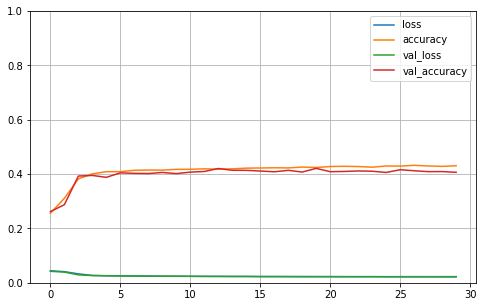

In [666]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.gca().set_ylim(0,1)
plt.grid()
plt.show()

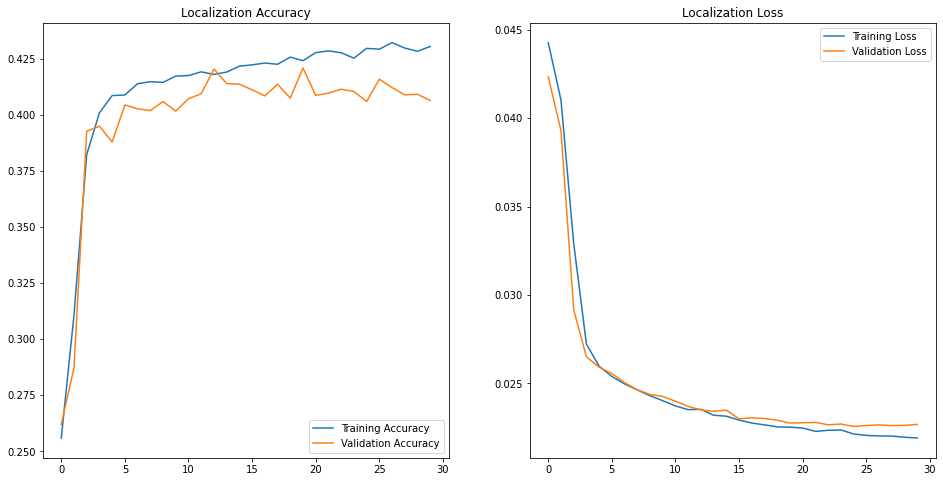

In [667]:
localization_accuracy = history.history['accuracy']
val_localization_accuracy = history.history['val_accuracy']

localization_loss = history.history['loss']
val_localization_loss = history.history['val_loss']

x_range = range(len(history.history['loss']))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(x_range, localization_accuracy, label='Training Accuracy')
plt.plot(x_range, val_localization_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Localization Accuracy')

plt.subplot(1, 2, 2)
plt.plot(x_range, localization_loss, label='Training Loss')
plt.plot(x_range, val_localization_loss, label='Validation Loss')
plt.legend()
plt.title('Localization Loss')
plt.show()

1/1 [==============================] - 0s 66ms/step
[[0.3525668  0.17059012 0.38128352 0.15558535]]
Koordynaty końców lini wyznaczone przez sieć: (x = 22, y = 10) i (x = 24, y = 9)


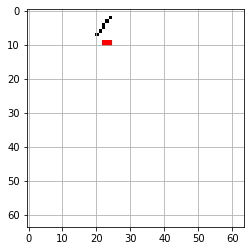

In [668]:
test_img_path = 'images/testing/line1.png'

img = keras.preprocessing.image.load_img(test_img_path, target_size=(height, width))
img = keras.preprocessing.image.img_to_array(img)
img = tf.expand_dims(img, 0)
predictions = model.predict(img)
print(predictions)
coords = predictions[0]
coords = [int(coords[0] * width), int(coords[1] * height), int(coords[2] * width), int(coords[3] * height)]
print(f"Koordynaty końców lini wyznaczone przez sieć: (x = {coords[0]}, y = {coords[1]}) i (x = {coords[2]}, y = {coords[3]})")


testimg = keras.preprocessing.image.load_img(test_img_path, target_size=(height, width))
box = Draw(testimg)
box.rectangle(coords, outline='red')
plt.grid()
plt.imshow(testimg)

1/1 [==============================] - 0s 16ms/step
[[0.23607412 0.69253623 0.21248832 0.7393364 ]]
Coordinates of line: (15,44) and (13,47)
1/1 [==============================] - 0s 15ms/step
[[0.6175572  0.73021424 0.62655115 0.6913997 ]]
Coordinates of line: (39,46) and (40,44)
1/1 [==============================] - 0s 15ms/step
[[0.42340064 0.43525475 0.45270774 0.47895187]]
Coordinates of line: (27,27) and (28,30)
1/1 [==============================] - 0s 13ms/step
[[0.5334297  0.49697566 0.5497153  0.53889954]]
Coordinates of line: (34,31) and (35,34)
1/1 [==============================] - 0s 20ms/step
[[0.54412854 0.42012262 0.55921996 0.444564  ]]
Coordinates of line: (34,26) and (35,28)
1/1 [==============================] - 0s 17ms/step
[[0.6214219  0.45064884 0.62553126 0.42273363]]
Coordinates of line: (39,28) and (40,27)
1/1 [==============================] - 0s 15ms/step
[[0.76014125 0.50768954 0.771002   0.5274849 ]]
Coordinates of line: (48,32) and (49,33)
1/1 [========

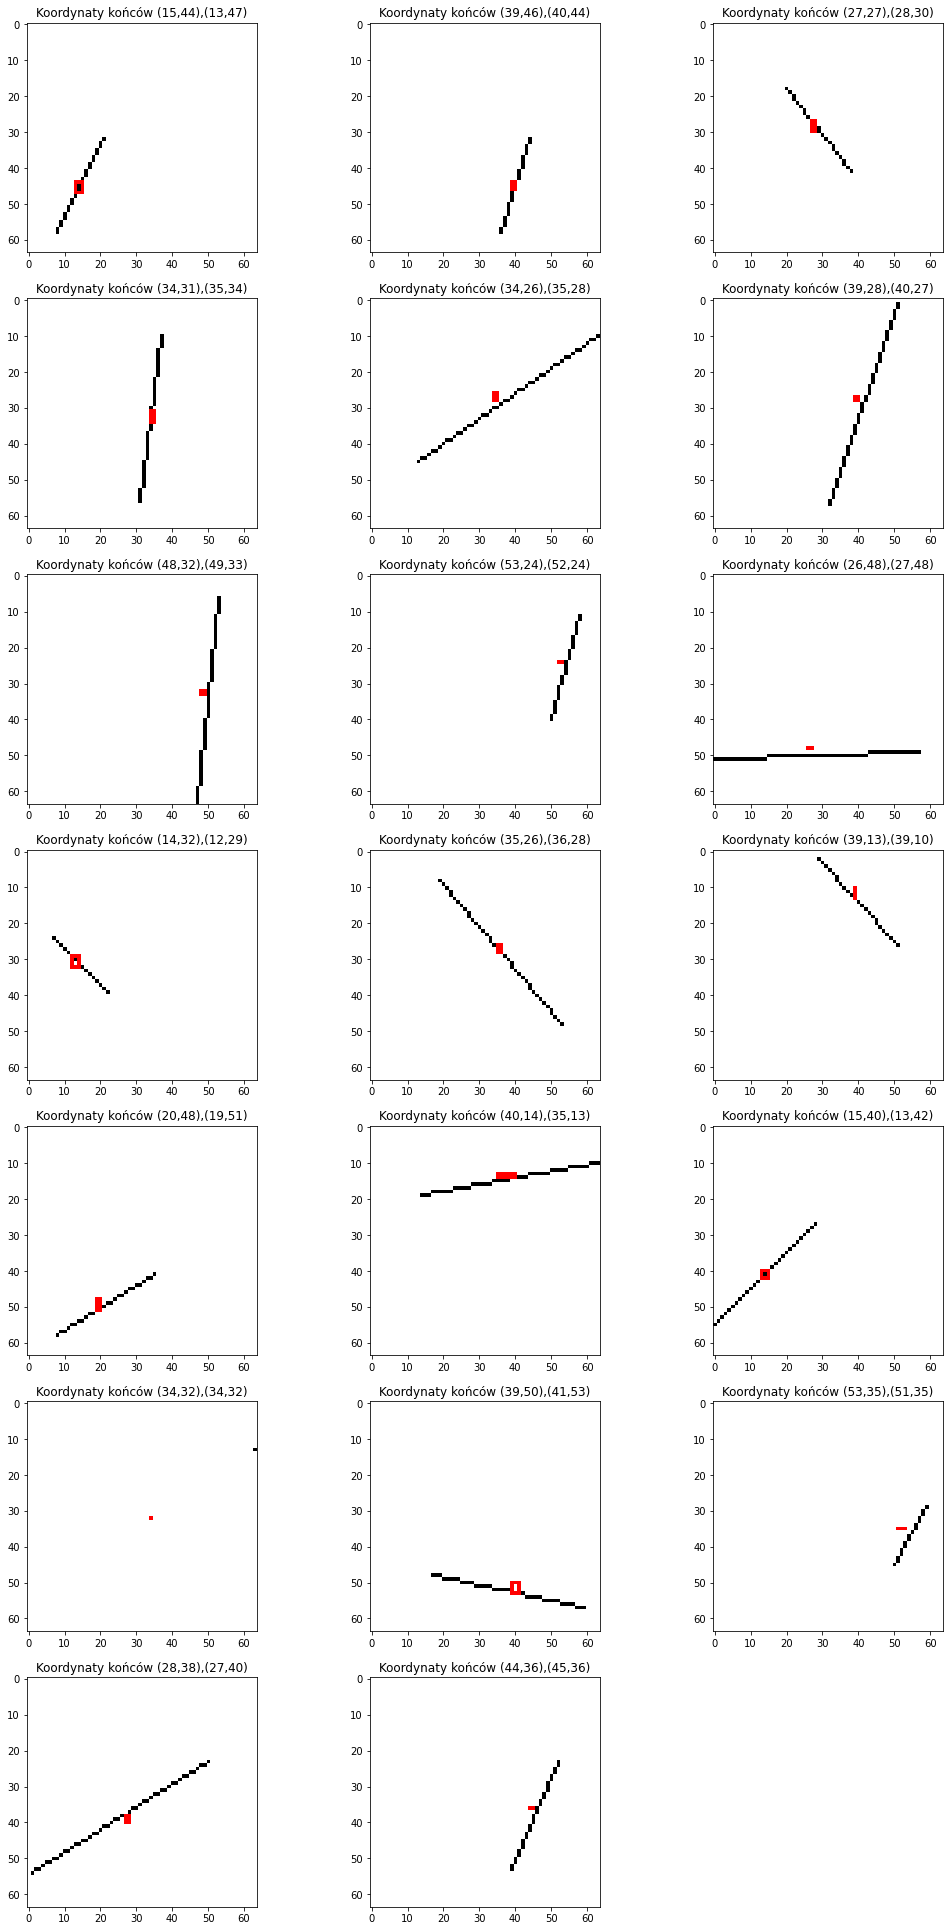

In [669]:
test_dir = pathlib.Path('images/testing')
img_paths = list(test_dir.glob('*.png'))
img_paths = img_paths[:20]
fig = plt.figure(figsize=(20, 20))

for i, img_path in enumerate(img_paths):
    image = keras.preprocessing.image.load_img(img_path, target_size=(height, width))
    img_arr = keras.preprocessing.image.img_to_array(image)
    img_arr = tf.expand_dims(img_arr, 0)
    
    predictions = model.predict(img_arr)
    print(predictions)
    coords = predictions[0]
    coords = [int(coords[0] * width), int(coords[1] * height), int(coords[2] * width), int(coords[3] * height)]
    print(f"Coordinates of line: ({coords[0]},{coords[1]}) and ({coords[2]},{coords[3]})")

    box = Draw(image)
    box.rectangle(coords, outline='red', width=1)
    
    ax = plt.subplot(8, 3, i+1)
    plt.subplots_adjust(bottom=0, right=0.8, top=1.5)
    plt.imshow(image)
    plt.title(f"Koordynaty końców ({coords[0]},{coords[1]}),({coords[2]},{coords[3]})")

In [670]:
# Read testing set
TESTING_CSV_FILE = 'images/Data/testing_data.csv'
TESTING_IMAGE_DIR = 'images/testing'

test_image_records = pd.read_csv(TESTING_CSV_FILE)
test_image_path = os.path.join(os.getcwd(), TESTING_IMAGE_DIR)

test_images = []
test_coords = []

for index, row in test_image_records.iterrows():
    (filename, width, height, xmin, ymin, xmax, ymax) = row
    
    test_image_fullpath = os.path.join(test_image_path, filename)
    test_img = load_img(test_image_fullpath, target_size=(height, width))
    test_img_arr = img_to_array(test_img)
    
    test_images.append(test_img_arr)
    test_coords.append((xmin, ymin, xmax, ymax))

In [671]:
pred_coords = []
for i in test_images[:20]:
    i = tf.expand_dims(i, 0)
    predictions = model.predict(i)
    predictions = predictions[0]
    predictions = [int(predictions[0] * width), int(predictions[1] * height), int(predictions[2] * width), int(predictions[3] * height)]
    pred_coords.append(predictions)

1/1 [==============================] - 0s 27ms/step


In [672]:
def IOU(coords1, coords2):
    x1, y1, w1, h1 = coords1[0], coords1[1], coords1[2], coords1[3]
    x2, y2, w2, h2 = coords2[0], coords2[1], coords2[2], coords2[3]
    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:
        return 0.
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

In [674]:
# Calculate the mean IOU between the predicted and expected bounding boxes on the test dataset. 
sum_IOU = 0.
for i in range(len(pred_coords)):
    sum_IOU += IOU(pred_coords[i], test_coords[i])
mean_IOU = sum_IOU / len(pred_coords)
print(f'Mean Intersection over Union = {mean_IOU}')

Mean Intersection over Union = 0.32180861462890087


Możliwości poprawy:  
-Tuning hiperparametrów sieci  
-Zmiany w architekturze sieci  
-Skorzystanie z gotowego modelu (np. którejś z wersji YOLO)  
-Zamiana funkcji straty na L2  
-data batch generator(przyśpieszy uczenie i zaoszczędzi pamięć)  
